# Import backage

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from models.models_new import Renorm_Dynamic
from dynamic_models_sis_new import Simple_Spring_Model
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Five parallel experiments

In [3]:
# part samples
experiments = 5
mul_batch_size = [0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 30001

eis_nis_e = np.zeros([experiments,T_total//500+1])
losses_nis_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nis_e = np.zeros([experiments,T_total//500+1])
eis_nisp_e = np.zeros([experiments,T_total//500+1])
losses_nisp_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nisp_e = np.zeros([experiments,T_total//500+1])

In [ ]:
# nis
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=0.01) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=0.01)
    
    eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, T2=T_total,framework='nis')
    eis_nis_e[e,:] = eis_nis
    losses_nis_e[e,:] = losses_nis
    MAEs_mstep_nis_e[e,:] = MAEs_mstep_nis

check point-------o_0-> 17:33:10.108008; lasting 0:01:07.363151 seconds
Epoch: 0
Train loss: 0.5174
dEI: 0.3344
term1: -0.7183
term2: 1.3871
Test multistep loss: 0.6344
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 17:33:15.363449; lasting 0:00:05.255441 seconds
check point-------o_0-> 17:33:22.492798; lasting 0:00:07.129349 seconds
Epoch: 500
Train loss: 0.0769
dEI: 1.3173
term1: 0.9763
term2: 1.6584
Test multistep loss: 0.0981
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 17:33:29.428341; lasting 0:00:06.935543 seconds
check point-------o_0-> 17:33:37.167722; lasting 0:00:07.739381 seconds
Epoch: 1000
Train loss: 0.0360
dEI: 1.7664
term1: 1.8401
term2: 1.6927
Test multistep loss: 0.0592
--------------------------------------------------------------------------------------------------------

In [ ]:
# nis+
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=0.01) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=0.01)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, T2=T_total,framework='nis+')
    eis_nisp_e[e,:] = eis_nisp
    losses_nisp_e[e,:] = losses_nisp
    MAEs_mstep_nisp_e[e,:] = MAEs_mstep_nisp

check point-------o_0-> 10:31:49.210708; lasting 7:15:24.812984 seconds
Epoch: 0
Train loss: 0.5174
dEI: 0.3344
term1: -0.7183
term2: 1.3871
Test multistep loss: 0.6005
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 10:31:54.474742; lasting 0:00:05.264034 seconds
check point-------o_0-> 10:32:04.636284; lasting 0:00:10.161542 seconds
Epoch: 500
Train loss: 0.0780
dEI: 1.3226
term1: 0.9906
term2: 1.6546
Test multistep loss: 0.1012
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 10:32:11.527094; lasting 0:00:06.890810 seconds
check point-------w_0-> 10:32:24.016743; lasting 0:00:12.489649 seconds
check point-------w_1-> 10:32:24.027506; lasting 0:00:00.010763 seconds
check point-------w_2-> 10:34:54.833969; lasting 0:02:30.806463 seconds
check point-------w_3-> 10:34:54.853058; lasting 0:00:00.01

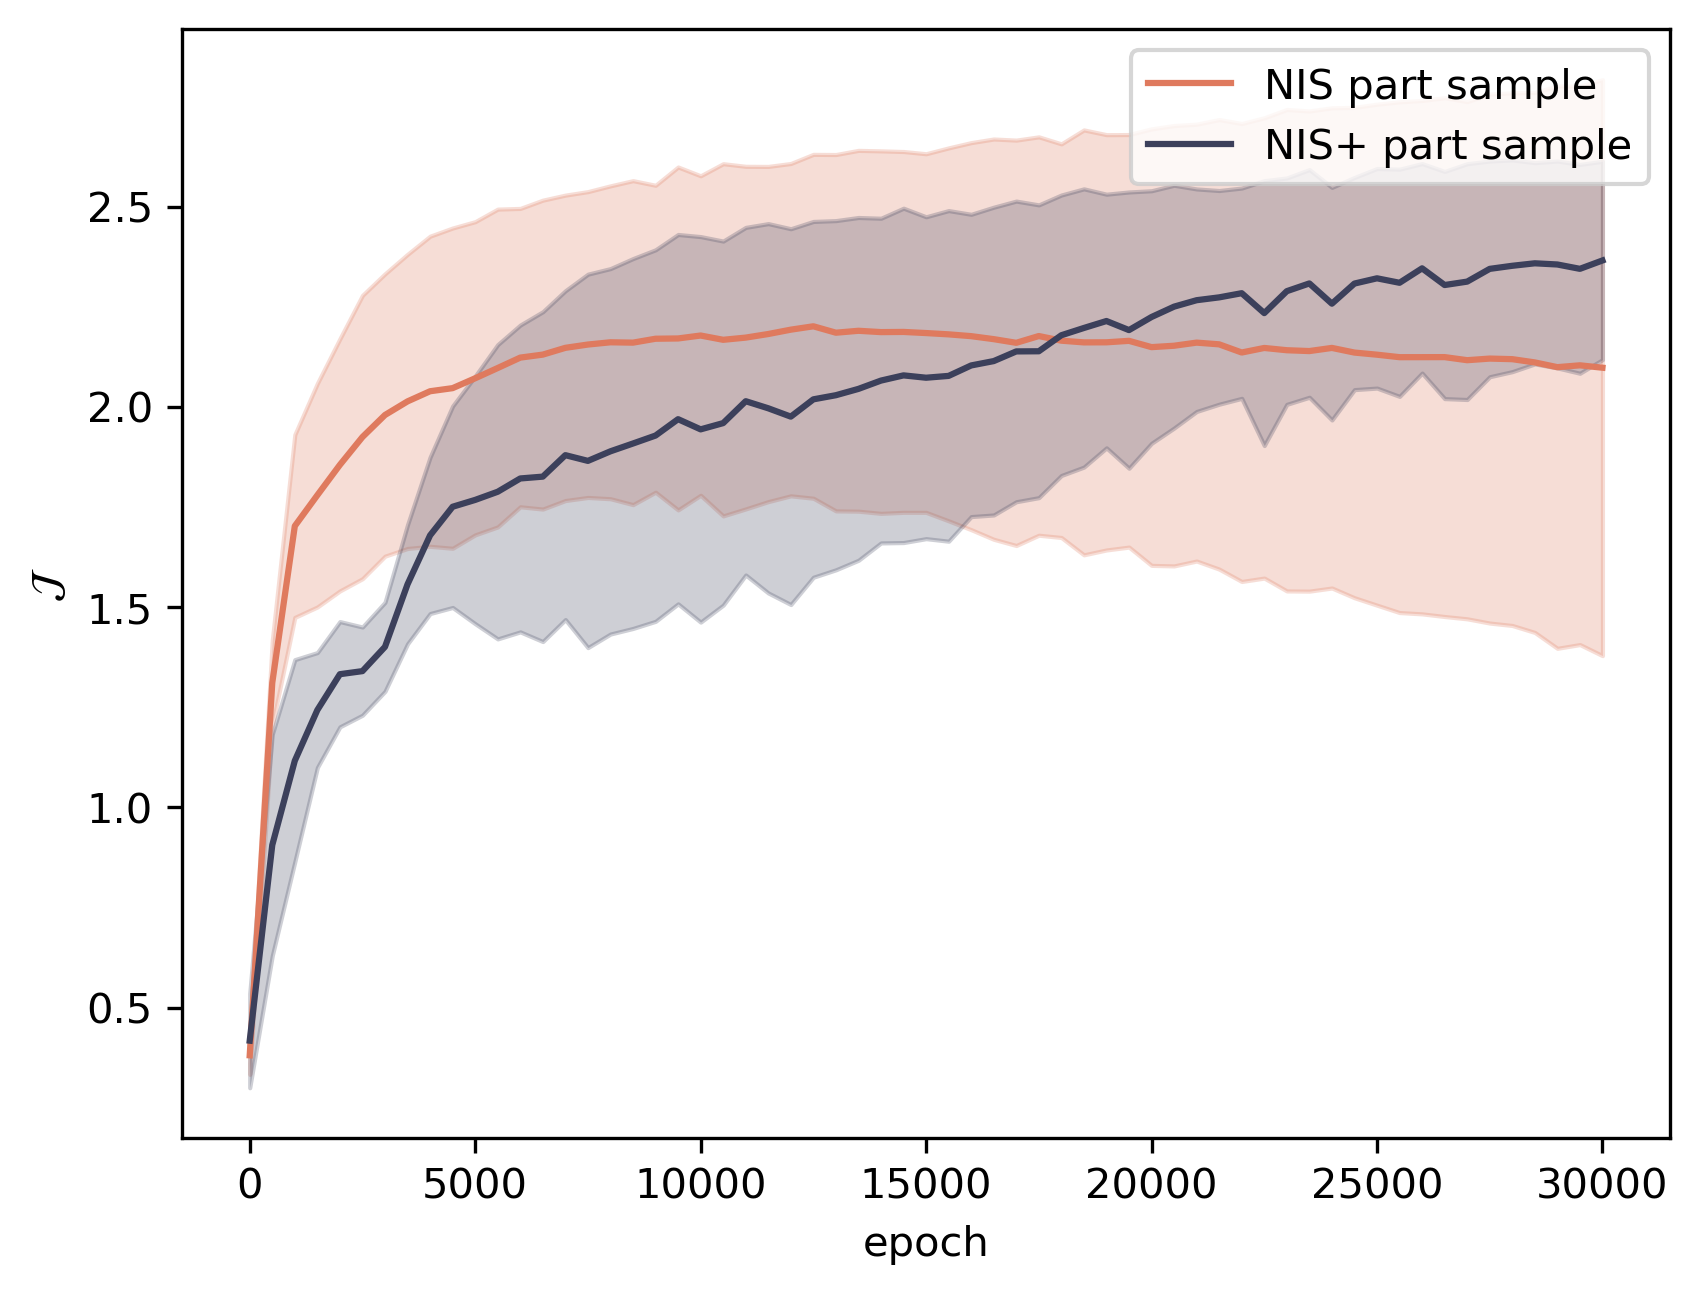

In [9]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_nis))*500
means_nis = np.mean(eis_nis_e,axis=0)
stds_nis = np.std(eis_nis_e,axis=0)
means_nisp = np.mean(eis_nisp_e,axis=0)
stds_nisp = np.std(eis_nisp_e,axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel(r'$\mathcal{J}$')
plt.show()

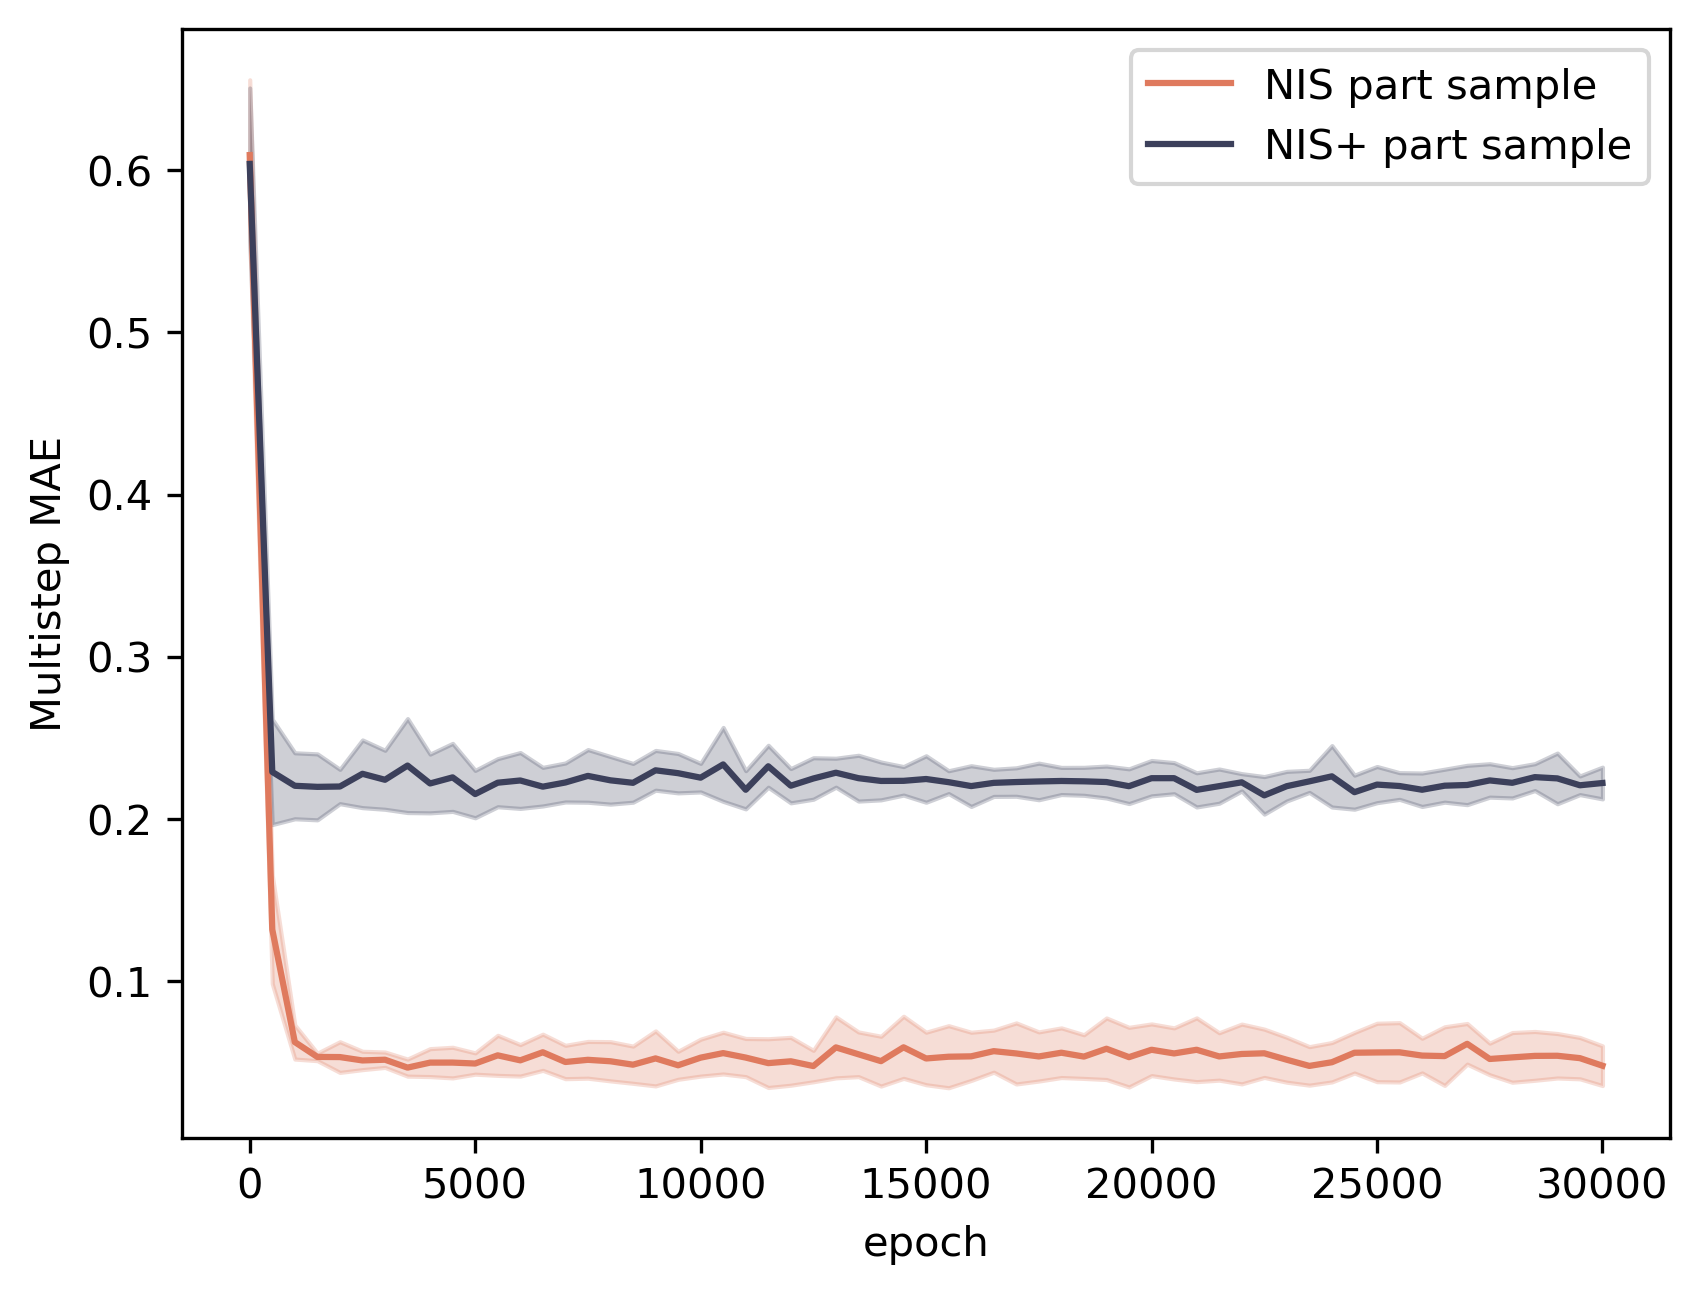

In [11]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_nis))*500
means_nis = np.mean(MAEs_mstep_nis_e,axis=0)
stds_nis = np.std(MAEs_mstep_nis_e,axis=0)
means_nisp = np.mean(MAEs_mstep_nisp_e,axis=0)
stds_nisp = np.std(MAEs_mstep_nisp_e,axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel('Multistep MAE')
plt.show()